In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import numpy.random as npr


In [2]:
import csv
with open('reviews_foodborne.csv') as f:
    reader = csv.reader(f)
    reader.next()
    pos_data = [ row[0] for row in reader if float(row[1]) == 1.0]
with open('reviews_foodborne.csv') as f:
    reader = csv.reader(f)
    reader.next()
    neg_data = [ row[0] for row in reader if float(row[1]) == 0.0]

In [12]:
def print_topics(model, vocab, top_k=10):
    topic_words = model.topic_word_
    for i, topic_dist in enumerate(topic_words):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(top_k+1):-1]
        print('\tTopic {}: {}'.format(i+1, ', '.join(topic_words)))
        print
    print

In [11]:
all_data = pos_data + neg_data
labels = np.concatenate((np.ones(len(pos_data)), np.zeros(len(neg_data)))).astype(int)
cv = CountVectorizer('content', strip_accents='unicode', analyzer='word', stop_words='english', max_df=.9, min_df=2, ngram_range=(1,1))
X = cv.fit_transform(all_data)
y = labels
vocab = [x[0] for x in sorted(cv.vocabulary_.items(), key=lambda x:x[1])]


In [4]:
print X.shape, y.shape
n_topics = 10

(5394, 10731) (5394,)


In [10]:
from disclda.lda import DiscLDA
model = DiscLDA(n_topics=n_topics, n_iter=1000, random_state=0)
model.fit(X,y)

<disclda.lda.DiscLDA instance at 0x10abfbab8>

In [63]:
def run_disclda(data, labels, n_topics=10, n_per=1, n_iter=1000, random_state=0):
    print "Running LDA with %i topics and %i iterations..." % (n_topics, n_iter)
    cv = CountVectorizer('content', strip_accents='unicode', analyzer='word', stop_words='english', max_df=.9, min_df=2, ngram_range=(1,1))
    X = cv.fit_transform(data)
    vocab = [x[0] for x in sorted(cv.vocabulary_.items(), key=lambda x:x[1])]
    print "(N,V): ",X.shape
    print
    model = DiscLDA(n_topics=n_topics, n_per=n_per, n_iter=1000, random_state=0)
    model.fit(X, labels)
    results = {'n_topics':n_topics,
               'n_iter':n_iter,
               'vocab':vocab,
               'model':model,
               'X':X,
               'cv':cv
              }
    return results

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

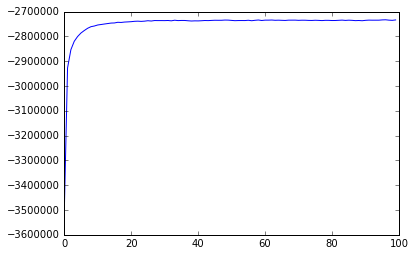

In [13]:
plt.plot(model.loglikelihoods_)

In [14]:
print_topics(model, vocab)

	Topic 1: like, cream, sweet, tea, cake, chocolate, ice, coffee, delicious, just

	Topic 2: food, poisoning, got, night, day, sick, place, stomach, ate, eating

	Topic 3: sick, place, good, great, like, bar, really, nice, just, food

	Topic 4: order, sick, food, said, called, told, manager, restaurant, know, asked

	Topic 5: place, food, people, like, don, just, health, sick, store, dirty

	Topic 6: came, food, table, minutes, service, restaurant, didn, time, waiter, waitress

	Topic 7: food, sushi, sick, place, got, ordered, chicken, poisoning, fish, good

	Topic 8: burger, chicken, sick, cheese, food, like, ordered, got, fries, place

	Topic 9: food, place, sick, ve, good, just, don, like, pizza, really

	Topic 10: sauce, good, chicken, like, just, dish, pork, ordered, soup, restaurant




In [15]:
from pyhealth.models import models as m, documents as d, businesses as b, locations as l
db = m.getDBSession()

In [16]:
%%time
reviews = db.query(d.YelpReview).limit(100000).all()

CPU times: user 3.28 s, sys: 471 ms, total: 3.75 s
Wall time: 3.8 s


In [38]:
%%time
sample = [ r.text for r in np.random.choice(reviews, size=19900, replace=False)]
posn = 100
data = pos_data[:posn] + sample
labels = np.concatenate((np.ones(posn), np.zeros(len(sample)))).astype(int)

CPU times: user 185 ms, sys: 6.91 ms, total: 192 ms
Wall time: 188 ms


In [110]:
%%time
result_mixed = run_disclda(data, labels, n_topics=20, n_per=1, n_iter=500)

Running LDA with 20 topics and 500 iterations...
(N,V):  (20000, 19504)

CPU times: user 3min 2s, sys: 418 ms, total: 3min 3s
Wall time: 3min 3s


In [40]:
print_topics(result['model'], result['vocab'])

	Topic 1: coffee, place, tea, great, store, good, shop, nice, selection, friendly

	Topic 2: sick, food, stomach, ate, poisoning, disgusting, bathroom, diarrhea, vomiting, work

	Topic 3: like, just, didn, wasn, taste, did, really, menu, time, little

	Topic 4: food, great, place, amazing, service, love, best, time, ve, friendly

	Topic 5: like, don, just, place, know, people, time, want, make, think

	Topic 6: food, order, service, asked, said, time, didn, just, minutes, ordered

	Topic 7: food, good, chicken, tacos, sauce, rice, mexican, delicious, place, great

	Topic 8: bar, place, drinks, beer, night, great, drink, good, music, nice

	Topic 9: pork, ramen, soup, chinese, good, dumplings, noodles, place, food, broth

	Topic 10: burger, fries, cheese, good, sandwich, chicken, meat, just, like, burgers

	Topic 11: new, location, york, ve, best, city, street, restaurant, old, park

	Topic 12: chicken, rice, thai, spicy, food, good, sauce, fried, dish, dishes

	Topic 13: table, wait, c

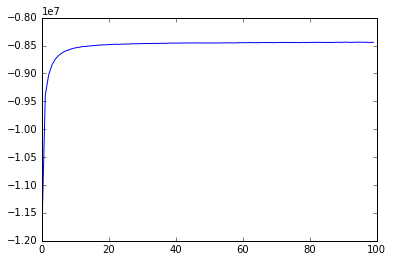

In [41]:
plt.plot(result['model'].loglikelihoods_)

In [113]:
thetas = result_mixed['model'].doc_topic_

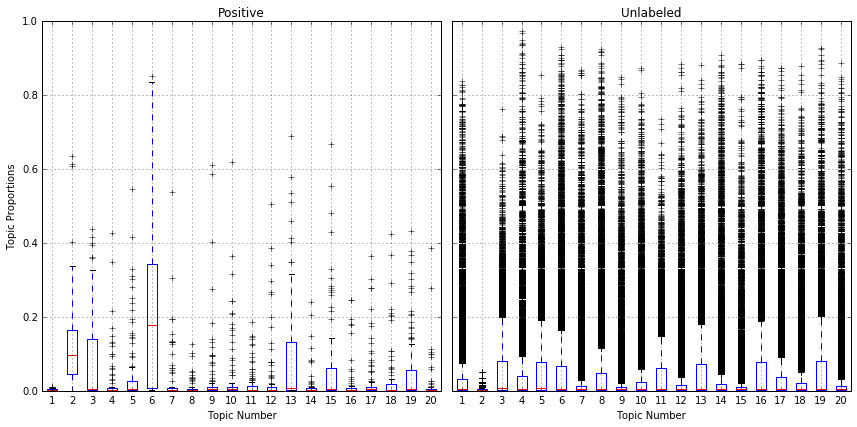

In [115]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6), sharey=True)
ax0.boxplot(thetas[:posn])
ax0.grid()
ax0.set_title("Positive")
ax0.set_xlabel("Topic Number")
ax0.set_ylabel("Topic Proportions")
ax1.boxplot(thetas[posn:])#np.random.randint(2500,10000,size=2500),:])
ax1.grid()
ax1.set_title("Unlabeled")
ax1.set_xlabel("Topic Number")

plt.tight_layout()
#plt.savefig('lda_boxplot_2500_7500.pdf')

Running LDA with 20 topics and 500 iterations...
(N,V): 

 (10000, 13835)
	Topic 1: chicken, food, salad, thai, good, rice, lunch, sauce, place, ordered

	Topic 2: sick, food, got, ate, day, stomach, soup, disgusting, poisoning, worst

	Topic 3: pork, ramen, soup, noodles, dumplings, chinese, spicy, good, fried, rice

	Topic 4: great, food, place, service, staff, friendly, delicious, love, amazing, definitely

	Topic 5: pizza, good, italian, cheese, sauce, slice, pasta, fresh, place, crust

	Topic 6: table, came, food, got, wait, ordered, time, minutes, didn, service

	Topic 7: dish, wine, meal, dinner, restaurant, ordered, menu, delicious, dessert, sauce

	Topic 8: bar, place, great, good, music, night, nice, drinks, people, like

	Topic 9: ve, place, best, new, time, food, don, times, just, years

	Topic 10: sushi, good, place, roll, food, fish, fresh, really, lunch, special

	Topic 11: food, good, chicken, tacos, mexican, like, just, place, ordered, great

	Topic 12: brunch, delicious, eggs, good, breakfast, cake, toast, french, coffee, br

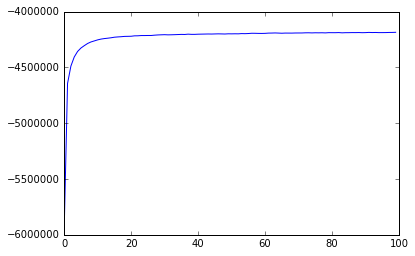

In [36]:
result1 = run_disclda(data, labels, n_topics=20, n_per=0, n_iter=500)
print_topics(result['model'], result['vocab'])
plt.plot(result['model'].loglikelihoods_)

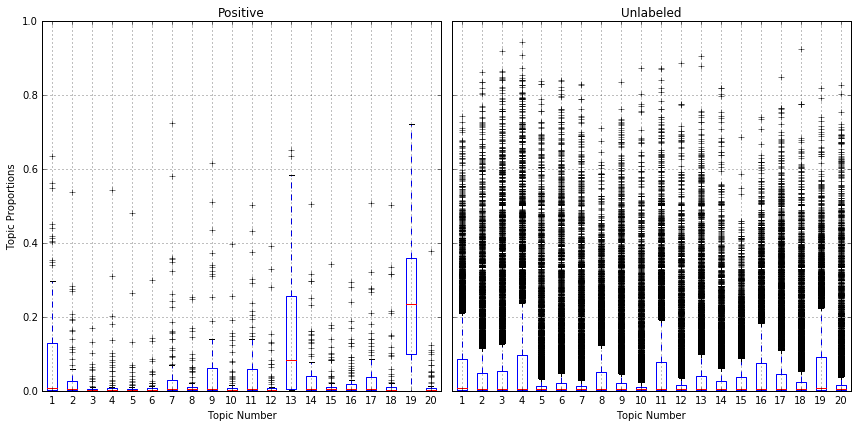

In [37]:
thetas = result1['model'].doc_topic_
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6), sharey=True)
ax0.boxplot(thetas[:posn])
ax0.grid()
ax0.set_title("Positive")
ax0.set_xlabel("Topic Number")
ax0.set_ylabel("Topic Proportions")
ax1.boxplot(thetas[posn:])#np.random.randint(2500,10000,size=2500),:])
ax1.grid()
ax1.set_title("Unlabeled")
ax1.set_xlabel("Topic Number")

plt.tight_layout()

### Testing out what the sum of the $\alpha_2$'s look like

In [58]:
bids = db.query(b.Business.id).limit(100).all()
print bids

[(u'--5Vr7RE9QXEKGBPSqZ7KA',), (u'--ermiD_aia8aiptGGd7CQ',), (u'--kedvpjB1PT28X_gArafA',), (u'--TWmuY9VLGM3gv1rDCTsg',), (u'--v7a67JPXBuUCOEc9hfCA',), (u'--xl8O3MKYoJ3FP8dNvmaw',), (u'--xwcBljFLvrFDGIQn5f3g',), (u'--YBn9-xi4YocUK6VvCKqQ',), (u'--ZRgp0sxIFwuwe9ZwcOtw',), (u'-__YENukvtf_chmLOUba2w',), (u'-_4i_FQ1Tt_aMU904O82Ow',), (u'-_fDmhClugYdfy19qcNQpw',), (u'-_kj-IG6iUO_NWp2bIyNeg',), (u'-_KPTha74ROkgv7jc-ikkg',), (u'-_LnInI1H-W94O9bRRAz2A',), (u'-_LtKO0FdpINUMAWMfDOOQ',), (u'-_S0v-bHKi82LH_ZGGtmIA',), (u'-_UoTl6xxnSMaMG72tyXxg',), (u'-_uvUljw1BxfmqxYY2yhiA',), (u'-_Z17vynLE_4QHTluuBsPg',), (u'-01ZWbo_tFb--3A_cvYXSQ',), (u'-0Am9mmzsXLW0PYYvrgeFA',), (u'-0bdnX762vdTb9lI00etvA',), (u'-0bpc5pvK6siYMIlCSmXWg',), (u'-0BZGO3BzV4W7klj1hf1YQ',), (u'-0dPYmVtfC__WWs-UE3r0w',), (u'-0fjWWC2SY6kNxGfD8PKGg',), (u'-0m-p6b9amvk3YMpAAVl1A',), (u'-0rMc_wb4gi6_sai0SadsQ',), (u'-0YTqofxupHzmd9SbKhjXw',), (u'-134ZvJ4lgiqx-sjRBWQ9g',), (u'-18UK8sE859Vvh6Ijwj8_w',), (u'-1Bdwxo5wx-D_9Qwfggk4g',), (u'-1D8R-

In [59]:
revs = db.query(d.YelpReview).filter(b.YelpReview.business_id.in_(bids)).all()

In [62]:
print len(revs)

8669


In [60]:
bd = {}
for r in revs:
    try:
        bd[r.business_id].append(r)
    except KeyError:
        bd[r.business_id] = [r]

In [61]:
for a in bd.items():
#     print a
    print "%r: %r" % (a[0], len(a[1]))

u'-1D8R-SddH0ML4917e5mLg': 8
u'-3n1itPDf8PKWzLTPuEN2g': 2
u'-3Gj4IrIu5Dn0LIZxidwkA': 12
u'-4oRsGaCKCMllrBGnIXN1Q': 26
u'--YBn9-xi4YocUK6VvCKqQ': 16
u'-4qDAN9ZQUmgyzrni_VXmw': 1
u'-207j4phxjuI5oH7wtC7Zw': 2
u'-2aMphgYYnoxncuZ7xI3Gw': 352
u'-2O70w9j1fqeACklZESFvg': 95
u'-4wt4Uau_zC5ilPMrIayxQ': 1
u'--v7a67JPXBuUCOEc9hfCA': 2
u'-0bpc5pvK6siYMIlCSmXWg': 228
u'-37T4Bf_j-pPYFenzHKzjg': 16
u'-_KPTha74ROkgv7jc-ikkg': 2
u'-_4i_FQ1Tt_aMU904O82Ow': 35
u'-3nFb3WH7XvzaE8ExRSR7g': 2
u'-1iJcPWDeBjdcwPoAp831A': 1
u'-6wpiKE7vCkFVb7GLCVcIw': 91
u'-4IzKUlUCEyW9AgZ9ZTCFw': 115
u'-5HaBXNz-3nMpvmvFauvuw': 547
u'-6JbLyKKWSrCmI3e_Kc1fg': 4
u'-6ncX3fnQ9OLCjfiUe-kFg': 295
u'-01ZWbo_tFb--3A_cvYXSQ': 132
u'-1RgCe93_xeBzgnM_7PnhQ': 7
u'-1I-0ksslfmM-DizHItCkw': 1
u'-5JwknVLIT36YTGhvkuBaw': 53
u'-18UK8sE859Vvh6Ijwj8_w': 15
u'-0dPYmVtfC__WWs-UE3r0w': 1
u'--xwcBljFLvrFDGIQn5f3g': 18
u'-78KGJqSFFNnlN6B0ptung': 135
u'-0BZGO3BzV4W7klj1hf1YQ': 28
u'-3cDMhUL6qs5B_hCguTiXQ': 101
u'-6fuEFileON30RutMiloPw': 27
u'-_kj-IG6iUO_N

In [82]:
def transform_doc(preprocess, model, doc):
    X = preprocess.transform([doc])
    #print X
    #print np.nonzero(X)
    return model.transform(X)

In [67]:
print type(revs[0].created)

<type 'datetime.datetime'>


In [84]:
import logging
logging.getLogger("lda").setLevel(logging.ERROR)
ts = {}
for r in revs:
    try:
        ts[r.business_id].append((r.created, r.text, transform_doc(result['cv'], result['model'], r.text)))
    except KeyError:
        ts[r.business_id] = [(r.created, r.text, transform_doc(result['cv'], result['model'], r.text))]

In [86]:
tops = [ v[2] for rs in ts.values() for v in rs]
print len(tops)

8669


In [98]:
tps = np.array(tops).reshape(8669,20)

{'boxes': [<matplotlib.lines.Line2D at 0x12b1a0210>,
 'caps': [<matplotlib.lines.Line2D at 0x12b1b14d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x12b1be990>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x12b1be510>,
 'whiskers': [<matplotlib.lines.Line2D at 0x12b1a0490>,
  <matplotlib.lines.Line2D at 0x144f35fd0>]}

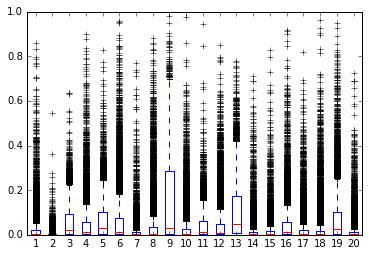

In [99]:
plt.boxplot(tps)

In [101]:
fps = [t[1] for t in tps]

(array([ 34.,  29.,  16.,  11.,   5.,   1.,   1.,   0.,   0.,   3.]),
 array([  4.20168067e-04,   6.40623618e-02,   1.27704556e-01,
          1.91346749e-01,   2.54988943e-01,   3.18631137e-01,
          3.82273330e-01,   4.45915524e-01,   5.09557718e-01,
          5.73199912e-01,   6.36842105e-01]),
 <a list of 10 Patch objects>)

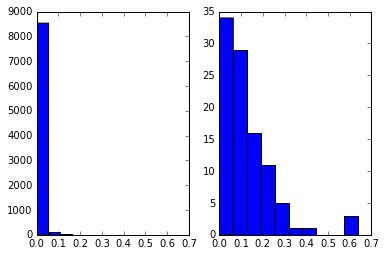

In [116]:
fig, (ax0, ax1) = plt.subplots(1,2, sharex=True)
ax0.hist(fps)
ax1.hist(thetas[:posn,1])